# Time Series DNN Uncertainty Analyze

This notebook loads the deep learning models of the time series classification (second part of the time-series-ml-analyze.ipynb notebook) and takes a deeper look into them. It further investigates the uncertainty of the models as well as using a few methods to enhance or reduce the uncertainty.

In [1]:
%pip install -qqq torch torchinfo tsai

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import pickle

from _defaults import (
    SEED,
    datasets_labels,
    get_data_hash_key,
    init_notebook,
    load_ballance_datasets,
    print_db_length_table,
)
import numpy as np
from tabulate import tabulate
import torch

In [4]:
init_notebook()

Load (limited amount of) data.

In [5]:
data_limit = 1000
_, (dataset, metadata, targets) = load_ballance_datasets(max_length=data_limit)

Load previous cached dataset from './cache/datasets-18f8d4b7.pkl' file.


In [6]:
print_db_length_table(targets)

Dataset         Length
------------  --------
Fernverkehr       1000
Güterverkehr      1000
Regioverkehr      1000


Prepare caching.

In [7]:
data_hash = get_data_hash_key()

Devices to use for PyTorch.

In [8]:
device = torch.device("cpu")  # CPU is good enough for a single prediction/classification
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### tsai library data preparation

In [9]:
from fastai.data.transforms import Categorize
from tsai.data.core import TSDataLoaders, TSDatasets
from tsai.data.preprocessing import ReLabeler
from tsai.data.validation import get_splits

In [10]:
X = np.atleast_3d(dataset).transpose(0, 2, 1)
y = np.array(targets)

In [11]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (3000, 1, 1000)
y.shape: (3000,)


Classes mapping.

In [12]:
class_map = dict(enumerate(datasets_labels))
print(tabulate(class_map.items(), headers=["target", "label"]))

labeler = ReLabeler(class_map)
y = labeler(y)

  target  label
--------  ------------
       0  Fernverkehr
       1  Güterverkehr
       2  Regioverkehr


Datset splitting (train, test, validation) using tsai library.

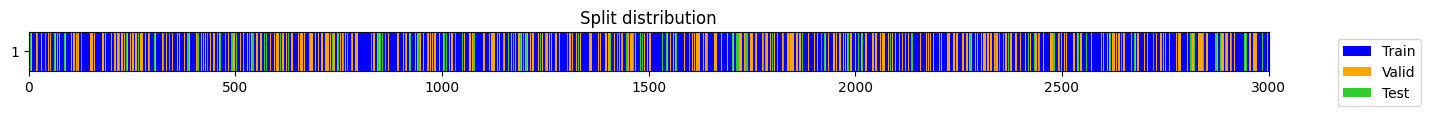

In [13]:
splits = get_splits(
    y,
    n_splits=1,
    valid_size=0.3,
    test_size=0.1,
    shuffle=True,
    balance=True,
    stratify=True,
    random_state=SEED,
    show_plot=True,
    verbose=True,
)

Dataset and data loaders.

In [14]:
tfms = [None, [Categorize()]]
dataset = TSDatasets(X, y, tfms=tfms, splits=splits)

bs = 256
dataloader = TSDataLoaders.from_dsets(dataset.train, dataset.valid, bs=[bs, bs * 2])

### Common

In [15]:
def expected_entropy(predictions: torch.Tensor) -> torch.Tensor:
    """Calculate the mean entropy of the predictive distribution."""
    return torch.distributions.Categorical(probs=predictions).entropy().mean(dim=0)

In [16]:
def predictive_entropy(predictions: torch.Tensor) -> torch.Tensor:
    """Calculate the entropy of the mean predictive distribution."""
    return torch.distributions.Categorical(probs=predictions.mean(dim=0)).entropy()

In [17]:
def mutual_information(predictions: torch.Tensor) -> torch.Tensor:
    """Calculate the BALD (Bayesian Active Learning by Disagreement) of a model."""
    return predictive_entropy(predictions) - expected_entropy(predictions)

In [18]:
def print_var_std_table(predictions: torch.Tensor) -> None:
    print(
        tabulate(
            [
                ["variance:", *predictions.var(dim=0).tolist()],
                ["std:", *predictions.std(dim=0).tolist()],
            ],
            tablefmt="plain",
            floatfmt=".4f",
        )
    )

In [19]:
inp = torch.from_numpy(X[splits[2]][[0]]).to(torch.float32).to(device)
target = y[splits[2]][0]

### Multiple models with different architectures

Loading the shortly trained models with different architectures.

In [20]:
cache_file = f"./cache/tsai-dl-models-{data_hash}-{data_limit}.pkl"
assert os.path.exists(cache_file), "previous trained models not found"

print(f"Load previous trained models from '{cache_file}' file.")
with open(cache_file, "rb") as f:
    models, results = pickle.load(f)
archs, hyperparams, models = zip(*models, strict=True)
display(results)

Load previous trained models from './cache/tsai-dl-models-18f8d4b7-1000.pkl' file.


,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,ResNet,{},478595,0.414141,0.398937,0.848889,11
1,LSTM,"{'n_layers': 3, 'bidirectional': True}",566203,1.016371,0.958154,0.531111,23
2,RNNPlus,"{'n_layers': 4, 'bidirectional': False}",71203,1.039516,1.002445,0.500000,5
3,GRUPlus,"{'n_layers': 3, 'bidirectional': True}",424803,1.018175,0.986746,0.483333,16
4,GRU,"{'n_layers': 3, 'bidirectional': True}",424803,1.012894,0.978381,0.482222,15
5,LSTMPlus,"{'n_layers': 3, 'bidirectional': True}",566203,1.025075,0.988323,0.480000,23
6,RNN,"{'n_layers': 3, 'bidirectional': True}",142003,1.029547,0.991794,0.478889,6
7,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",142003,1.069921,1.046916,0.430000,7
8,RNNPlus,"{'n_layers': 4, 'bidirectional': True}",202403,1.060398,1.023392,0.430000,9
9,LSTM,"{'n_layers': 3, 'bidirectional': False}",203103,1.098189,1.098713,0.333333,12


#### Deep Ensemble Uncertainty

In [21]:
def print_prediction_results(predictions: torch.Tensor) -> None:
    print(
        tabulate(
            {
                "model": archs,
                "hyper parameters": hyperparams,
                "predicted class": torch.argmax(predictions, dim=1).tolist(),
            },
            headers="keys",
        )
    )
    print("")
    print("target class:", list(filter(lambda key: class_map[key] == target, class_map))[0], f"({target})")

Classify first test sample.

In [22]:
predictions = None
for model in models:
    model = model.to(device)
    np_output = model(inp).detach().cpu()
    model = model.cpu()

    if predictions is None:
        predictions = np_output
    else:
        predictions = torch.vstack((predictions, np_output))

predictions

tensor([[-1.4981e-01, -5.4756e-01, -2.2051e-01],
        [ 8.8179e-02, -2.2661e-01,  5.3326e-02],
        [ 3.0697e-02,  3.5823e-02,  8.7321e-02],
        [-6.0138e-03, -2.5246e-01, -3.6731e-02],
        [-4.9446e-01, -3.5040e-01, -1.9865e-01],
        [ 1.8890e-01,  2.1870e-01,  2.2196e-01],
        [-7.9552e-02, -5.0068e-02,  2.0795e-01],
        [ 5.5528e-01, -4.1361e-01,  7.9230e-02],
        [-4.2757e-02,  5.2938e-02, -2.3412e-02],
        [-4.4263e+00,  7.1102e+00, -4.4609e+00]])

In [23]:
print_prediction_results(predictions)

model                                   hyper parameters                           predicted class
--------------------------------------  ---------------------------------------  -----------------
<class 'tsai.models.RNNPlus.RNNPlus'>   {'n_layers': 3, 'bidirectional': True}                   0
<class 'tsai.models.RNNPlus.LSTMPlus'>  {'n_layers': 3, 'bidirectional': True}                   0
<class 'tsai.models.RNNPlus.GRUPlus'>   {'n_layers': 3, 'bidirectional': True}                   2
<class 'tsai.models.RNNPlus.RNNPlus'>   {'n_layers': 4, 'bidirectional': True}                   0
<class 'tsai.models.RNNPlus.RNNPlus'>   {'n_layers': 4, 'bidirectional': False}                  2
<class 'tsai.models.RNN.LSTM'>          {'n_layers': 3, 'bidirectional': False}                  2
<class 'tsai.models.RNN.RNN'>           {'n_layers': 3, 'bidirectional': True}                   2
<class 'tsai.models.RNN.LSTM'>          {'n_layers': 3, 'bidirectional': True}                   0
<class 'ts

In [24]:
print_var_std_table(predictions)

variance:  2.0377  5.3564  2.0287
std:       1.4275  2.3144  1.4243


To calculate further metrix like predictive_entropy, expected_entropy and mutual_info, which requires the "predictions" in range [0, 1], we can add a softmax layer at the end of the models.

In [25]:
predictions = None
for model in models:
    m = torch.nn.Sequential(model, torch.nn.Softmax())  # <<<<<<<<< add softmax
    m = m.to(device)
    np_output = m(inp).detach().cpu()
    m = m.cpu()

    if predictions is None:
        predictions = np_output
    else:
        predictions = torch.vstack((predictions, np_output))

predictions

tensor([[3.8409e-01, 2.5804e-01, 3.5787e-01],
        [3.7096e-01, 2.7078e-01, 3.5826e-01],
        [3.2643e-01, 3.2811e-01, 3.4545e-01],
        [3.6346e-01, 2.8407e-01, 3.5247e-01],
        [2.8578e-01, 3.3007e-01, 3.8415e-01],
        [3.2639e-01, 3.3626e-01, 3.3736e-01],
        [2.9735e-01, 3.0625e-01, 3.9640e-01],
        [4.9982e-01, 1.8968e-01, 3.1050e-01],
        [3.2052e-01, 3.5270e-01, 3.2678e-01],
        [9.7673e-06, 9.9998e-01, 9.4346e-06]])

In [26]:
print_prediction_results(predictions)

model                                   hyper parameters                           predicted class
--------------------------------------  ---------------------------------------  -----------------
<class 'tsai.models.RNNPlus.RNNPlus'>   {'n_layers': 3, 'bidirectional': True}                   0
<class 'tsai.models.RNNPlus.LSTMPlus'>  {'n_layers': 3, 'bidirectional': True}                   0
<class 'tsai.models.RNNPlus.GRUPlus'>   {'n_layers': 3, 'bidirectional': True}                   2
<class 'tsai.models.RNNPlus.RNNPlus'>   {'n_layers': 4, 'bidirectional': True}                   0
<class 'tsai.models.RNNPlus.RNNPlus'>   {'n_layers': 4, 'bidirectional': False}                  2
<class 'tsai.models.RNN.LSTM'>          {'n_layers': 3, 'bidirectional': False}                  2
<class 'tsai.models.RNN.RNN'>           {'n_layers': 3, 'bidirectional': True}                   2
<class 'tsai.models.RNN.LSTM'>          {'n_layers': 3, 'bidirectional': True}                   0
<class 'ts

In [27]:
print_var_std_table(predictions)

variance:  0.0161  0.0520  0.0130
std:       0.1269  0.2280  0.1142


In [28]:
print(expected_entropy(predictions.unsqueeze(0)).tolist())
print(expected_entropy(predictions).tolist())

[1.0848217010498047, 1.0893795490264893, 1.0982816219329834, 1.0929172039031982, 1.0913398265838623, 1.0985023975372314, 1.08984375, 1.025111198425293, 1.0977455377578735, 0.00024104198382701725]
0.9768183827400208


In [29]:
print(predictive_entropy(predictions.unsqueeze(0)).tolist())
print(predictive_entropy(predictions).tolist())

[1.0848217010498047, 1.0893795490264893, 1.0982816219329834, 1.0929172039031982, 1.0913398265838623, 1.0985023975372314, 1.08984375, 1.025111198425293, 1.0977455377578735, 0.00024104198382701725]
1.0963053703308105


In [30]:
print(mutual_information(predictions.unsqueeze(0)).tolist())
print(mutual_information(predictions).tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.1194869875907898


### ResNet

Loading the longer trained ResNet.

In [31]:
cache_file = f"./cache/tsai-dl-resnet-{data_hash}-{data_limit}.pkl"
assert os.path.exists(cache_file), "previous trained ResNet not found"

print(f"Load previous trained ResNet from '{cache_file}' file.")
with open(cache_file, "rb") as f:
    learn = pickle.load(f)
learn.model = learn.model.to(device)
model = learn.model

Load previous trained ResNet from './cache/tsai-dl-resnet-18f8d4b7-1000.pkl' file.


In [32]:
from sklearn.metrics import accuracy_score
from tsai.inference import get_X_preds  # noqa: F401  # patch learner with get_X_preds method

In [33]:
# on test sets
probas, test_targets, preds = learn.get_X_preds(X[splits[2]], y[splits[2]])
learn.model = learn.model.to(device)

model_score = accuracy_score(np.argmax(probas, axis=-1), test_targets)
print(f"test score {model_score}")

test score 0.8633333333333333


#### Common

In [34]:
N = 10

In [35]:
def print_prediction_results(predictions: torch.Tensor) -> None:
    print(tabulate({"#": range(N), "predicted class": torch.argmax(predictions, dim=1).tolist()}, headers="keys"))
    print("")
    print("target class:", list(filter(lambda key: class_map[key] == target, class_map))[0], f"({target})")

#### Input Noise Ensemble Uncertainty

1. predict an input N times, but each time added with (different) random noise
2. calc uncertainty

In [36]:
def get_input_with_noise(inp: torch.Tensor) -> torch.Tensor:
    return (torch.rand(inp.shape, device=device) * 2 - 1) * (inp.std() / 2)

In [37]:
predictions = None
for n in range(N):
    # first prediction without additional noise
    noise = get_input_with_noise(inp) if n > 0 else torch.zeros_like(inp, device=device)
    np_output = model(inp + noise).detach().cpu()

    if predictions is None:
        predictions = np_output
    else:
        predictions = torch.vstack((predictions, np_output))

predictions

tensor([[-7.4775, 10.6848, -7.3342],
        [-3.0593,  2.1392, -3.2649],
        [-3.6736,  3.2426, -3.1862],
        [-3.7594,  2.2497, -2.4077],
        [-4.0792,  3.6871, -3.4796],
        [-4.7452,  3.6588, -2.9821],
        [-5.2959,  5.2728, -4.0769],
        [-3.8163,  2.3590, -2.5375],
        [-4.8363,  4.2874, -3.5592],
        [-4.0701,  3.1612, -3.3032]])

In [38]:
print_prediction_results(predictions)

  #    predicted class
---  -----------------
  0                  1
  1                  1
  2                  1
  3                  1
  4                  1
  5                  1
  6                  1
  7                  1
  8                  1
  9                  1

target class: 1 (Güterverkehr)


In [39]:
print_var_std_table(predictions)

variance:  1.5339  6.3383  1.9433
std:       1.2385  2.5176  1.3940


To calculate further metrix like predictive_entropy, expected_entropy and mutual_info, which requires the "predictions" in range [0, 1], we can add a softmax layer at the end of the models.

In [40]:
predictions = None
m = torch.nn.Sequential(model, torch.nn.Softmax())  # <<<<<<<<< add softmax
for n in range(N):
    # first prediction without additional noise
    noise = get_input_with_noise(inp) if n > 0 else torch.zeros_like(inp, device=device)
    np_output = m(inp + noise).detach().cpu()

    if predictions is None:
        predictions = np_output
    else:
        predictions = torch.vstack((predictions, np_output))

predictions

tensor([[1.2948e-08, 1.0000e+00, 1.4943e-08],
        [6.7729e-05, 9.9984e-01, 9.2628e-05],
        [2.4021e-04, 9.9966e-01, 1.0244e-04],
        [5.9240e-05, 9.9984e-01, 9.7523e-05],
        [4.2041e-04, 9.9115e-01, 8.4294e-03],
        [3.5582e-04, 9.9765e-01, 1.9910e-03],
        [3.4276e-04, 9.9453e-01, 5.1302e-03],
        [2.4087e-04, 9.9850e-01, 1.2570e-03],
        [2.5536e-04, 9.9963e-01, 1.1949e-04],
        [1.5576e-04, 9.9942e-01, 4.2905e-04]])

In [41]:
print_prediction_results(predictions)

  #    predicted class
---  -----------------
  0                  1
  1                  1
  2                  1
  3                  1
  4                  1
  5                  1
  6                  1
  7                  1
  8                  1
  9                  1

target class: 1 (Güterverkehr)


In [42]:
print_var_std_table(predictions)

variance:  0.0000  0.0000  0.0000
std:       0.0001  0.0029  0.0028


In [43]:
print(expected_entropy(predictions.unsqueeze(0)).tolist())
print(expected_entropy(predictions).tolist())

[5.638531206386688e-07, 0.0016707491595298052, 0.0032855519093573093, 0.0016340487636625767, 0.05233787000179291, 0.017551898956298828, 0.03524215519428253, 0.011899084784090519, 0.0035665901377797127, 0.005277089774608612]
0.013246560469269753


In [44]:
print(predictive_entropy(predictions.unsqueeze(0)).tolist())
print(predictive_entropy(predictions).tolist())

[5.638531206386688e-07, 0.0016707491595298052, 0.0032855519093573093, 0.0016340487636625767, 0.05233787000179291, 0.017551898956298828, 0.03524215519428253, 0.011899084784090519, 0.0035665901377797127, 0.005277089774608612]
0.014972297474741936


In [45]:
print(mutual_information(predictions.unsqueeze(0)).tolist())
print(mutual_information(predictions).tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0017257370054721832


### Monte Carlo Dropout Uncertainty

1. Add some dropout layers inside the ResNet model
2. set all dropout layer into training mode
3. predict N times
4. calc uncertainty

#### 1. Add some dropout layers inside the ResNet model

In [46]:
from torchinfo import summary

In [47]:
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─ResBlock: 1-1                          --
│    └─ConvBlock: 2-1                    --
│    │    └─Conv1d: 3-1                  448
│    │    └─BatchNorm1d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    └─ConvBlock: 2-2                    --
│    │    └─Conv1d: 3-4                  20,480
│    │    └─BatchNorm1d: 3-5             128
│    │    └─ReLU: 3-6                    --
│    └─ConvBlock: 2-3                    --
│    │    └─Conv1d: 3-7                  12,288
│    │    └─BatchNorm1d: 3-8             128
│    └─ConvBlock: 2-4                    --
│    │    └─Conv1d: 3-9                  64
│    │    └─BatchNorm1d: 3-10            128
│    └─Add: 2-5                          --
│    └─ReLU: 2-6                         --
├─ResBlock: 1-2                          --
│    └─ConvBlock: 2-7                    --
│    │    └─Conv1d: 3-11                 57,344
│    │    

In [48]:
# This method is a modified version of the following source:
# https://discuss.pytorch.org/t/dynamically-insert-new-layer-at-middle-of-a-pre-trained-model/66531/3
def insert_module(model, indices, modules):
    indices = indices if isinstance(indices, list) else [indices]
    modules = modules if isinstance(modules, list) else [modules]
    assert len(indices) == len(modules)

    layers_name = [name for name, _ in model.named_modules()][1:]
    for index, module in zip(indices, modules, strict=True):  # noqa: B007
        layer_name = layers_name[index]
        exec(f"model.{layer_name} = torch.nn.Sequential(model.{layer_name}, module)")

In [49]:
insert_module(
    model,
    [0, 17, 34, 50],
    [torch.nn.Dropout(0.25), torch.nn.Dropout(0.25), torch.nn.Dropout(0.25), torch.nn.Dropout(0.5)],
)

In [50]:
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Sequential: 1-1                        --
│    └─ResBlock: 2-1                     --
│    │    └─ConvBlock: 3-1               576
│    │    └─ConvBlock: 3-2               20,608
│    │    └─ConvBlock: 3-3               12,416
│    │    └─ConvBlock: 3-4               192
│    │    └─Add: 3-5                     --
│    │    └─ReLU: 3-6                    --
│    └─Dropout: 2-2                      --
├─Sequential: 1-2                        --
│    └─ResBlock: 2-3                     --
│    │    └─ConvBlock: 3-7               57,600
│    │    └─ConvBlock: 3-8               82,176
│    │    └─ConvBlock: 3-9               49,408
│    │    └─ConvBlock: 3-10              8,448
│    │    └─Add: 3-11                    --
│    │    └─ReLU: 3-12                   --
│    └─Dropout: 2-4                      --
├─Sequential: 1-3                        --
│    └─ResBlock: 2-5                     --
│ 

#### 2. set all dropout layer into training mode

In [51]:
for m in model.modules():
    if m.__class__.__name__.startswith("Dropout"):
        m.train()

#### 3. predict N time

In [52]:
predictions = None
for _ in range(N):
    np_output = model(inp).detach().cpu()

    if predictions is None:
        predictions = np_output
    else:
        predictions = torch.vstack((predictions, np_output))

predictions

tensor([[-11.8291,  14.0011, -12.3055],
        [-12.6039,  15.0286, -10.7558],
        [ -6.9868,  13.4692, -11.2106],
        [-10.8397,  10.1165,  -5.0995],
        [-16.7206,  22.1024, -10.3163],
        [-13.9115,  11.9712,  -5.4740],
        [-11.7409,  15.2283,  -8.8032],
        [-12.4294,  14.6807,  -7.4843],
        [-11.3545,  16.0740,  -9.5774],
        [-12.4301,  18.6838, -13.8215]])

In [53]:
print_prediction_results(predictions)

  #    predicted class
---  -----------------
  0                  1
  1                  1
  2                  1
  3                  1
  4                  1
  5                  1
  6                  1
  7                  1
  8                  1
  9                  1

target class: 1 (Güterverkehr)


#### 4. calc uncertainty

In [54]:
print_var_std_table(predictions)

variance:  5.9546  11.2781  7.9824
std:       2.4402   3.3583  2.8253


To calculate further metrix like predictive_entropy, expected_entropy and mutual_info, which requires the "predictions" in range [0, 1], we can add a softmax layer at the end of the models.

In [55]:
predictions = None
m = torch.nn.Sequential(model, torch.nn.Softmax())  # <<<<<<<<< add softmax
for _ in range(N):
    np_output = m(inp).detach().cpu()

    if predictions is None:
        predictions = np_output
    else:
        predictions = torch.vstack((predictions, np_output))

predictions

tensor([[3.5648e-14, 1.0000e+00, 2.7825e-12],
        [4.6357e-14, 1.0000e+00, 2.7866e-11],
        [7.0981e-12, 1.0000e+00, 2.8645e-13],
        [1.0012e-07, 1.0000e+00, 3.6701e-07],
        [2.0908e-16, 1.0000e+00, 3.0455e-13],
        [8.8989e-13, 1.0000e+00, 1.4863e-11],
        [6.8449e-07, 9.9999e-01, 4.8709e-06],
        [1.4919e-15, 1.0000e+00, 8.0164e-17],
        [5.3475e-14, 1.0000e+00, 1.3488e-12],
        [4.0803e-13, 1.0000e+00, 2.1990e-13]])

In [56]:
print_prediction_results(predictions)

  #    predicted class
---  -----------------
  0                  1
  1                  1
  2                  1
  3                  1
  4                  1
  5                  1
  6                  1
  7                  1
  8                  1
  9                  1

target class: 1 (Güterverkehr)


In [57]:
print_var_std_table(predictions)

variance:  0.0000  0.0000  0.0000
std:       0.0000  0.0000  0.0000


In [58]:
print(expected_entropy(predictions.unsqueeze(0)).tolist())
print(expected_entropy(predictions).tolist())

[1.1925422427339072e-07, 1.196543024661878e-07, 1.193270264820967e-07, 7.511285730288364e-06, 1.1921416387394856e-07, 1.194604237753083e-07, 7.484153320547193e-05, 1.192093321833454e-07, 1.1923165743610298e-07, 1.1921932241421018e-07]
8.330738637596369e-06


In [59]:
print(predictive_entropy(predictions.unsqueeze(0)).tolist())
print(predictive_entropy(predictions).tolist())

[1.1925422427339072e-07, 1.196543024661878e-07, 1.193270264820967e-07, 7.511285730288364e-06, 1.1921416387394856e-07, 1.194604237753083e-07, 7.484153320547193e-05, 1.192093321833454e-07, 1.1923165743610298e-07, 1.1921932241421018e-07]
9.422167750017252e-06


In [60]:
print(mutual_information(predictions.unsqueeze(0)).tolist())
print(mutual_information(predictions).tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1.091429112420883e-06
